# Evrişimli Sinir Ağları: Adım Adım

**Kaynak: **[deeplearning.ai](https://www.deeplearning.ai/) / Coursera / Prof. Andrew Ng

### [**Google Colab Üzerinde Çalıştırmak için Tıklayınız!**](https://colab.research.google.com/github/ayyucekizrak/Udemy_DerinOgrenmeyeGiris/tree/master/Evrisimli_Sinir_Aglari)

Bu uygulamada evrişim (CONV) ve ortaklama (POOL) katmanlarından oluşan bir Evrişimli Sinir Ağı (Convolutional Neural Network) oluşturacağız.  Uygulamamız aynı zamanda ileri yönlü hesaplamaları ve geriye yayılım algoritmasını da içerecek.

**Notasyon**:
- Köşeli parantez içerisinde üst indis $[l]$ belirtilen parametrenin $l.$ katmana ait olduğunu belirtmektedir.
    - Örnek: $a^{[4]}$, $4.$ katmanın aktivasyon değeridir. $W^{[5]}$ ve $b^{[5]}$ $5.$ katmanın parametreleridir.

- Parantez içerisinde üst indis $(i)$ parametrenin $i.$ örneğe ait olduğunu göstermektedir. 
    - Örnek: $x^{(i)}$, $i.$ eğitim örneğidir.
    
- Alt indis $i$, $i.$ nöronu belirtmektedir.
    - Örnek: $a^{[l]}_i$, $l.$ katmanın $i.$ nöronuna ait aktivasyon değerini belirtmektedir.
    
- $n_H$, $n_W$ ve $n_C$ sırasıyla yükseklik, genişlik ve kanal sayısını göstermektedir. Özellikle bir katmanı (örneğin $l.$ katman) belirtmek istiyorsanız köşeli parantez içinde üst indis kullanabilirsiniz $n_H^{[l]}$, $n_W^{[l]}$, $n_C^{[l]}$. 

## 1 - Kütüphaneler

İlk olarak kullanacağımız Python kütüphanelerini koda dahil edelim. 

- [Numpy](www.numpy.org) bilimsel hesaplamalar için 
- [Matplotlib](http://matplotlib.org) plotlama işlemlerini yapmak için
- np.random.seed(1) üretilen rastgele sayıların sabit olmasını sağlamak için

In [0]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - Uygulamaya Genel Bir Bakış

Evrişimli sinir ağımızı bloklar halinde oluşturacağız. Tanımlayacağımız fonksiyonlar şunları içeriyor:

- Evrişim fonksiyonları:
    - Sıfır dolgulama-piksel ekleme (Zero padding)
    - Evrişim penceresi (Convolve window) 
    - İleri yönlü evrişim 
    - Evrişimde geriye yayılım

- Ortaklama (pooling) fonksiyonları::
    - İleri yönlü ortaklama 
    - Maske oluşturma 
    - Değeri dağıtma 
    - Ortaklamada geriye yayılım

Yukarıda belirtilen fonksiyonları `Numpy` kütüphanesini kullanarak sıfırdan oluşturacağız. 

**Önemli Not:** İleri yönlü hesaplamaların ardından geriye yayılım algoritmasını gerçekleyeceğimiz için bazı parametrelerin geçici olarak hafızada tutulması gerekmektedir.

## 3 - Evrişimli Sinir Ağları

Kütüphanelerle hızlı bir şekilde evrişim işlemini yapabiliyor olsak da derin öğrenme içerisinde anlaşılması en zor konulardan bir tanesi evrişim işlemidir. Evrişim katmanında giriş hacim değeri (genelde) farklı boyutta bir çıkış hacmine dönüştürülür. 

Bu bölümde evrişim katmanını adım adım oluşturacağız. İlk olarak sıfır dolgulama (zero padding) ve evrişim değerlerini hesaplayan iki fonksiyonu tanımlayalım.

### 3.1 - Sıfır ile Dolgulama (Zero-Padding)

Sıfır dolgulama işleminde görüntünün etrafına sıfırlar eklenir.

Dolgulama işleminin avantajlarını şu şekilde belirtebiliriz: 

- Yükseklik ve genişlik değerlerini azaltmadan CONV katmanını kullanmamızı sağlar. Özellikle çok derin ağlarda bu çok önemlidir. Çünkü giriş görüntüsünün yükseklik ve genişliği katmanlarda ilerledikçe küçülürse çok değerin ağ tasarlamam mümkün olmayacaktır. Kütüphanelerde kullanılan 'same convolution' parametresi ile evrişim işlemi sonunda yükseklik ve genişlik değerleri korunmaktadır. 

- Kırpma işlemi olmadığı için görüntünün sınırlarındaki bilgilerde kayıp olmaz.

**Örnek**: X adet örnekten oluşan görüntü yığınında [np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html) kullanarak piksel ekleme işlemini yapalım. $(5,5,5,5,5)$ boyutundaki "a" dizisi için 2. boyutta `pad = 1`, 4. boyutta `pad = 3` ve kalanlar için `pad = 0` yapmak için: 

```python
a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), 'constant', constant_values = (..,..))
```

In [0]:
def zero_pad(X, pad):
    """
    X veri kümesinin tüm resimlerine piksel ekleme (padding) yapar.
    Pikseller yükseklik ve genişliğe uygulanır.
    
    Girdiler:
    X -- görüntü yığını (batch) {(m, n_H, n_W, n_C) boyutlu Numpy dizisi}
    pad -- dikey ve yatay boyutlarda eklenecek piksel miktarı {tam sayı}
        
    Çıktı:
    X_pad -- piksel eklenmiş durum {(m, n_H + 2*pad, n_W + 2*pad, n_C) boyutlu Numpy dizisi}
    """
    
    X_pad = np.pad(X, ((0,0), (pad, pad), (pad,pad), (0,0)), 'constant',  constant_values = 0)
    
    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


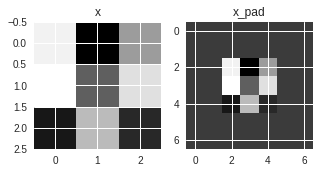

In [3]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)

print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

### 3.2 - Bir Adımlık Evrişim

Bu bölümde görüntünün belirli bir bölümüne evrişim filtresinden geçirerek bir adımlık evrişim işlemini gerçekleştireceğiz. Şu temel adımlar oluşmaktadır:

- Giriş görüntüsü alma
- Giriş değerinin her noktasına filtre uygulama
- Farklı boyutta (genelde) bir çıkış değeri üretme

Bilgisayarı görüde matrisin her bir değeri bir piksele karşılık gelmektedir. 3x3 boyutlu filtre ile evrişim işleminde; matrisin her bir elemanı filtrenin elemanları ile element-wise çarpılır ve bias değerleri ile toplanır. 

**Örnek**: conv_single_step() fonksiyonunu gerçekleyelim. [İpucu](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.sum.html)


In [0]:
def conv_single_step(a_slice_prev, W, b):
    """
    
    Tek adımlık evrişim işlemini gerçekleştirir.
    
    Girdiler:
    a_slice_prev -- (f, f, n_C_prev) boyutlu giriş verisi
    W -- (f, f, n_C_prev) boyutlu ağırlık değeri
    b -- (1, 1, 1) boyutlu bias değeri
    
    Çıktı:
    Z -- skaler çıkış değeri
    """

    # Giriş ile ağırlık değerlerinin çarpımı  
    s = np.multiply(a_slice_prev, W)
    # Toplama
    Z = np.sum(s)
    # Z'ye b bias değerini ekleme
    Z = float(b)+Z

    return Z

In [5]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


### 3.3 - Evrişimli Sinri Ağları - İleri Yönlü Hesaplama

İleri yönlü hesaplama yaparken giriş değerleri ile filtreler kullanılarak evrişim işlemi gerçekleştirilir. Her bir evrişim işlemi size 2 boyutlu matris çıktısı üretir. 3 boyutlu giriş görüntüsü için bunları art arda ekleriz.   
 

**Örnek**: Giriş aktivasyon değeri A_prev ile W filtrelerini kullanarak evrişim işlemini gerçekleştiren bir fonksiyon tanımlayalım. Bu fonksiyonda bir önceki katmanın m örneklik yığını için aktivasyon değeri A_prev, W ile gösterilen filtreler ve b bias vektörü kullanılır. Ayrıca kaydırma (stride) ve eklenecek piksel miktarını (padding) tutan "hparameters" sözlüğü de kullanılır. 

**İpucu**: 
1. (5,5,3) boyutlu "a_prev" üzerinde sol üst köşede 2x2 boyutundaki bir dilimi şu şekilde seçeriz: 

```python
a_slice_prev = a_prev[0:2,0:2,:]
```
2. a_slice'yı tanımlamak için öncelikle köşeleri belirlememeiz gerekir: `vert_start`, `vert_end`, `horiz_start` and `horiz_end`. 

**Hatırlatma**:
Giriş görüntüsüne göre çıkış görüntüsünün değeri şu şekilde bulunur:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{filtre sayısı}$$

In [0]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Evrişim fonksiyonu için ileri yönlü hesaplamalar
    
    Girdiler:
    A_prev -- bir önceki katmanın çıkış aktivasyon değeri {(m, n_H_prev, n_W_prev, n_C_prev) boyutlu Numpy dizisi}
    W -- Ağırlıklar {(f, f, n_C_prev, n_C) boyutlu Numpy dizisi}
    b -- Bias, {(1, 1, 1, n_C) boyutlu Numpy dizisi}
    hparameters -- "stride" ve "pad" değerlerini içeren sözlük
        
    Çıktılar:
    Z -- evrişim çıkışı {(m, n_H, n_W, n_C) boyutlu Numpy dizisi}
    cache -- conv_backward() fonksiyonu için gerekli değerler
    """
    
    # A_prev'in boyutlarını bulalım  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # W'nin boyutunu bulalım
    (f, f, n_C_prev, n_C) = W.shape
    
    # "hyperparameters" sözlüğünden hiperparametreleri alalım
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # CONV çıkış boyutunu tanımlayalım
    n_H = int(((n_H_prev-f+2*pad)/stride)+1)
    n_W = int(((n_W_prev-f+2*pad)/stride)+1)
    
    # Çıkış Z değerini sıfırlar ile ilklendirelim
    Z = np.zeros([m,n_H,n_W,n_C])
    
    # A_prev'a piksel ekleme yapalım
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                          # eğitim örnekleri üzerinde döngü
        a_prev_pad = A_prev_pad[i]              # i. örnek 
        for h in range(n_H):                    # çıkış değerinin dikey ekseninde döngü
            for w in range(n_W):                # çıkış değerinin yatay ekseninde döngü
                for c in range(n_C):            # çıkış değerinin kanalları üzerinde döngü
                    
                    # Köşeleri bulalım
                    vert_start = h*stride
                    vert_end = vert_start + f
                    horiz_start = w*stride
                    horiz_end = horiz_start + f
                    
                    # Köşeleri kullanalım 
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end]
                    
                    # Evrişim işlemini gerçekleştirelim
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[...,c], b[...,c])
                                            
    # Çıkış değerinin boyutunun doğruluğunu kontrol edelim
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Geriye yayılım için değerleri saklayalım
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [7]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

print("Z'nin ortalama =", np.mean(Z))
print("Z[3,2,1] =", Z[3,2,1])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z'nin ortalama = 0.048995203528855794
Z[3,2,1] = [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


Son olarak CONV katmanında aktivasyon fonksiyonu olmalı. Z değerini aktivasyon fonksiyonunda geçirirek aktivasyon değerini buluruz:

```python
# Evrişim işlemi gerçekleştir
Z[i, h, w, c] = ...

# Aktivasyon fonksiyonunu uygula
A[i, h, w, c] = activation(Z[i, h, w, c])
```

Burada bunu yapmayacağız.

## 4 - Ortaklama Katmanı 

Ortaklama katmanı (POOL) giriş görüntüsünün yükseklik ve genişlik değerini azaltır. Hesaplama yükünü azaltmanın yanında öznitelik tespit edicilerin (feature detector) giriş görüntüsünde konumdan bağımsız olarak öznitelik tespit etmesini sağlar. Sık kullanılan iki ortaklama türü vardır:

- Maksimum ortaklama (max-pooling) katmanı: ($f, f$) boyutundaki pencere giriş görüntüsü üzerinde kaydırılır ve pencere içerisinde yer alan "en büyük değer" çıkış değeri olarak saklanır.

- Ortalama ortaklama (average-pooing) katmanı: ($f, f$) boyutundaki pencere giriş görüntüsü üzerinde kaydırılır ve pencere içerisinde yer alan değerlerin "ortalaması" çıkış değeri olarak saklanır.

Ortaklama katmanında eğitim için hatanın geriye yayılımı sırasında kullanılacak herhangi bir parametre yoktur. Bu katmanda yalnızca pencere boyutu ($f$) hiperparametresinin seçimi yapılmaktadır.


### 4.1 - İleri Yönlü Ortaklama
Bu adımda aynı fonksiyon içerisinde ileri yönlü ortaklama için kullanacağız MAX-POOL ve AVG-POOL gerçeklemelerini yapacağız.


**Hatırlatma**:
Görüntünün etrafına herhangi bir dolgulama (padding) yapılmadığı için ortaklama işlemi sonucunda elde edilen çıkış değerinin boyutları şu şekilde hesaplanır:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$
$$ n_C = n_{C_{prev}}$$

In [0]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Ortaklama katmanı için ileri yönlü hesaplamalar gerçekleştirilir.
    
    Girdiler:
    A_prev -- Giriş verisi {(m, n_H_prev, n_W_prev, n_C_prev) boyutlu Numpy dizisi}
    hparameters -- f" ve "stride" değerlerini içeren sözlük {dictionary}
    mode -- ortaklama türü ("max" ya da "average")
    
    Çıktılar:
    A -- Ortaklama katmanı çıkışı {(m, n_H, n_W, n_C) boyutlu Numpy dizisi}
    cache -- Geriye yayılımda kullanılacak giriş değeri ile hparameters değerlerini içerir.
    """
    
    # Giriş değerinin boyutlarını bulalım
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # "hparameters" sözlüğünden hiperparametreleri alalım
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Çıkış değerinin boyutlarını tanımlayalım
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # A matrisini ilklendirelim
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):                          # eğitim örnekleri üzerinde döngü
        for h in range(n_H):                    # çıkış değerinin dikey ekseninde döngü
            for w in range(n_W):                # çıkış değerinin yatay ekseninde döngü
                for c in range (n_C):           # çıkış değerinin kanalları üzerinde döngü
                    
                    # Köşeleri bulalım
                    vert_start = h*stride
                    vert_end = vert_start + f
                    horiz_start = w*stride
                    horiz_end = horiz_start + f
                    
                    # i. eğitim örneği için köşe değerleri, A_prev ve kanal c'yi kullanalım
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    # Ortaklama işlemini moda (max ya da average) gerçekleştirelim
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
        
    # Giriş ve hiperparametreler değerlerini geriye yayılımda kullanmak üzere saklayalım
    cache = (A_prev, hparameters)
    
    # Çıkış değerinin doğrulığunu  kontrol edelim
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [9]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)

print("mod = max")
print("A =", A)
print()

A, cache = pool_forward(A_prev, hparameters, mode = "average")

print("mod = average")
print("A =", A)

mod = max
A = [[[[1.74481176 0.86540763 1.13376944]]]


 [[[1.13162939 1.51981682 2.18557541]]]]

mod = average
A = [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]


Tebrikler! Evrişim katmanının ileri yönlü hesaplamalarını tamamladık. Şimdi de geriye yayılımı gerçekleştirelim.

## 5 - Evrişimli Sinir Ağlarında Geriye Yayılım

Modern derin öğrenme kütüphanelerinde siz sadece ileri yönlü hesaplamaları gerçeklersiniz kütüphaneler geriye yayılımı halleder. Bu yüzden  derin öğrenme mühendisleri geriye yayılımla alakalı genelde problem yaşamazlar. Evrişimli sinir ağlarında geriye yayılım biraz karmaşıktır. 

Evrişim sinir ağlarında, klasik yapay sinir ağlarındakine benzer bir şekilde, parametreleri güncellemek için kısmi türev alma (gradyan) işlemini uygularız. 

### 5.1 - Geri Yönlü Hesaplama 

İlk olarak CONV katmanının geriye yayılımı gerçekleyelim.

#### 5.1.1 - dA'nın Hesaplanması:

$$ dA += \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

#### 5.1.2 - dW'nin Hesaplanması:

$$ dW_c  += \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

#### 5.1.3 - db'nin Hesaplanması:

$$ db = \sum_h \sum_w dZ_{hw} \tag{3}$$

In [0]:
def conv_backward(dZ, cache):
    """
    Evrişim fonksiyonu için geriye yayılım
    
    Girdiler:
    dZ -- maliyetin evrişim katmanının (Z) çıkışına göre gradyanı {(m, n_H, n_W, n_C) boyutlu Numpy dizisi}
    cache -- conv_backward() için conv_forward() fonksiyonunun çıkış değerleri
    
    Çıktılar:
    dA_prev -- Maliyetin evrişim katmanının girişine (A_prev) göre gradyanı 
               (m, n_H_prev, n_W_prev, n_C_prev) boyutlu Numpy dizis
    dW -- Maliyetin evrişim katmanının ağırlığına (W) göre gradyanı 
          (f, f, n_C_prev, n_C) boyutlu Numpy dizisi
    db -- Maliyetin evrişim katmanının bias değerlerine (b) göre gradyanı
          (1, 1, 1, n_C) boyutlu Numpy dizisi
    """
    
    # "cache" dan geçici değerleri alalım
    (A_prev, W, b, hparameters) = cache
    
    # A_prev'in boyutunu bulalım
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # W'nin boyutunu bulalım
    (f, f, n_C_prev, n_C) = W.shape
    
    # "hparameters" den hiperparametreleri alalım
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # dZ'nin boyutunu bulalım
    (m, n_H, n_W, n_C) = dZ.shape
    
    # dA_prev, dW ve db'yi ilklendirelim
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
    dW = np.zeros((f,f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    # Sıfır pikselleri ekleyelim
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                       # eğitim örnekleri üzerinde döngü
        
        # eğitim örneğini seçelim
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):                   # çıkış değerinin dikey ekseninde döngü
            for w in range(n_W):               # çıkış değerinin yatay ekseninde döngü
                for c in range(n_C):           # çıkış değerinin kanalları üzerinde döngü
                    
                    # Köşeleri bulalım
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    # keöşeleri kullanarak a_prev_pad üzerinde dilimi hesaplayalım
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    # Pencere için gradyanları ve filtre parametrelerini güncelleyelim
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    
    # Çıkış boyutunun doğruluğunun kontrol edelim
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

In [11]:
np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)

print("dA ortalama =", np.mean(dA))
print("dW ortalama =", np.mean(dW))
print("db ortalama =", np.mean(db))

dA ortalama = 0.6347704472654743
dW ortalama = 1.5572657428497354
db ortalama = 7.839232564616838


## 5.2 Ortaklama Katmanı - Geriye Yayılım

Ortaklama katmanında güncellenecek parametre olmamasına rağmen önceki katmanları hesaplamak için yine de geriye yayılımı gerçekleştirmenzi gerekmektedir.

### 5.2.1 Maksimum Ortaklama - Geriye Yayılım  

İlk olarak maksimum değerin konumunu 1 ve diğerlerini 0 yapan `create_mask_from_window()` fonksiyonunu tanımlayalım. 

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}\tag{4}$$

Yukarıda da görebileceğiniz üzere maske matrisi en büyük değerin konum bilgisini tutmaktadır. Maksimum değerde True(1) değeri var iken diğer değerler False(0) olarak tanımlanmaktadır.

In [0]:
def create_mask_from_window(x):
    """
    x giriş matrisinden en büyük değeri bulmak için maske oluşturur. 
    
    Girdi:
    x -- (f, f) boyutlu dizi
    
    Çıktı:
    mask -- x penceresi ile aynı boyutta ve x'in en büyük elemanına karşılık gelen konumda True.
    """
    
    mask = x == np.max(x)
    
    return mask

In [13]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)

print('x = ', x)
print("maske = ", mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
maske =  [[ True False False]
 [False False False]]


En büyük değeri neden tutuyoruz? İleri yönlü hesaplama sonrasında çıkışta oluşacak hataya etki eden değer maksimum değerdir. Geriye yayılım esnasında hataya etki eden değerin sıfırdan farklı bir gradyan değerine sahip olması gerekir. Hata geri yayılırken maksimum değer üzerinden yayılır. 

### 5.2.2 - Ortalama Ortaklama - Geriye Yayılım

Maksimum ortaklamada yalnızca en büyük değer çıkıştaki değere etki ederken, ortalama ortaklamada her bir değer eşit oranda etki eder.

Örneğin ileri yönlü hesaplamada 2x2 boyutlu filtre ile ortalama ortaklama yaparsak, geriye yayılım sırasında kullanacağımız maske şöyle olur:  
$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

In [0]:
def distribute_value(dz, shape):
    """
    Giriş değerini matris elemanlarına dağıtma.
    
    Girdi:
    dz -- skaler giriş değeri
    shape -- (n_H, n_W) boyutlu dizi
    
    Çıktı:
    a -- dz dağıtılmış (n_H, n_W) boyutlu dizi
    """
    
    # shape'in boyutunu bulalım
    (n_H, n_W) = shape
    
    # Matris üzerinde dağıtılacak değeri hesaplayalım 
    average = dz / (n_H * n_W)
    
    # Her bir değeri "average" olan matris oluşturalım
    a =  np.ones(shape) * average
    
    return a

In [15]:
a = distribute_value(2, (2,2))
print('Dağıtılmış değer =', a)

Dağıtılmış değer = [[0.5 0.5]
 [0.5 0.5]]


### 5.2.3 Ortaklama için Geriye Yayılım

**Örnek**: `pool_backward` fonksiyonunu her iki mod için (`"max"` ve `"average"`) tanımlayalım. 4 adet for-döngüsü (örnekler, yükseklik, genişlik ve kanal için) kullanacağız. 

In [0]:
def pool_backward(dA, cache, mode = "max"):
    """
    Ortaklama katmanı için geriye yayılımı gerçekler.
    
    Girdi:
    dA -- Maliyetin çıkış değerine göre gradyanı. {A ile aynı boyuta sahip}
    cache -- "input" ve "hparameters" değerleri içeren ileri yönlü hesaplamada kaydedilen geçici değerler 
    mode -- ortaklama modu ("max" ya da "average")
    
    Çıktı:
    dA_prev -- Maliyetin giriş değerine göre gradyanı. {A_prev ile aynı boyuta sahip}
    """
        
    # Geçici değerlerleri alalım
    (A_prev, hparameters) = cache
    
    # "hparameters" den hiperparametreleri alalım
    stride = hparameters['stride']
    f = hparameters['f']
    
    # A_prev ve dA'nın boyutunu bulalım
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # dA_prev'i sıfır değerleri ile ilklendirelim
    dA_prev = np.zeros(A_prev.shape)
 
    for i in range(m):                       # eğitim örnekleri üzerinde döngü
        
        # Eğitim örneğini seçelim
        a_prev = A_prev[i]
        
        for h in range(n_H):                   # dikey eksende döngü
            for w in range(n_W):               # yatay eksende döngü
                for c in range(n_C):           # kanallar üzerinde döngü
                    
                    # Köşeleri bulalım
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    # Her iki mod için geriye yayılımı hesaplayalım
                    if mode == "max":
                        
                        # köşeleri ve c kanalı için dilimi bulma
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        # a_prev_slice'dan maske oluşturma
                        mask = create_mask_from_window(a_prev_slice)
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) (≈1 line)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                        
                    elif mode == "average":
                        
                        # dA'dan a değerini alalım
                        da = dA[i,h,w,c]
                        # fxf boyutlu filtre tanımlayalım
                        shape = (f,f)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)
                            
    # Çıkış değerinin doğruluğunun kontrol edelim
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [0]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")

print("mod = max")
print('dA ortalaması = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()

dA_prev = pool_backward(dA, cache, mode = "average")

print("mod = average")
print('dA ortalaması = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mod = max
dA ortalaması =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mod = average
dA ortalaması =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
